In [1]:
import os
import glob

import GPRutils
import DESutils
import vK2KGPR

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

exps = DESutils.findExpNums()
gband = DESutils.bandDict["g"]
rband = DESutils.bandDict["r"]
iband = DESutils.bandDict["i"]
zband = DESutils.bandDict["z"]

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
expNum = exps[0]

In [3]:
dC = GPRutils.loadFITS(f"/home/fortino/GPRSolutions/simple/GPR.{expNum}.?RC.fits")
dC.summarize(noplots=True)

fitCorrParams = dC.fitCorrParams.copy()
finalParams = dC.params.copy()

Exposure: 348819
Band: z
Kernel Parameters from 2d Correlation Fitting
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
109.1565559    1.5349095      -0.0061141     0.0890528      -0.0355237     

Kernel Parameters from GPR Optimization
K Variance     Outer Scale    Diameter       Wind X         Wind Y         
220.7504306    0.5817545      -0.0084507     0.0122671      -0.030748      

Jackknifed xi+ (Inter-set pairs excluded)
xi0: 83.083 ± 1.693 mas^2
xif: 5.641 ± 0.486 mas^2
Reduction: 14.729



In [4]:
def printXi(dC):
    GPRutils.printParams(dC.params)
    xi0, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid)
    xierr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"xi0: {xi0:.3f} ± {xierr:.3f} mas^2")
    
    xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
    xierr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"xif: {xif:.3f} ± {xierr:.3f} mas^2")
    print(f"Reductin: {xi0/xif:.3f}")
    print()

In [5]:
# Get xi for final params

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(finalParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

220.7504306    0.5817545      -0.0084507     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 7.377 ± 1.337 mas^2
Reductin: 11.105



In [10]:
# Get xi for fitCorr params

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(fitCorrParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

109.1565559    1.5349095      -0.0061141     0.0890528      -0.0355237     
xi0: 81.926 ± 4.118 mas^2
xif: 12.289 ± 1.523 mas^2
Reductin: 6.667



In [6]:
# Test fitCorr K effect on final params
testParams = np.array([
    fitCorrParams[0],
    finalParams[1],
    finalParams[2],
    finalParams[3],
    finalParams[4]
])

GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
GP.fit(testParams)
GP.predict(dC.Xvalid)
xif, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
xiferr = np.sqrt(Xerr**2 + Yerr**2)
printXi(dC)

109.1565559    0.5817545      -0.0084507     0.0122671      -0.030748      
xi0: 81.926 ± 4.118 mas^2
xif: 8.032 ± 1.338 mas^2
Reductin: 10.200



In [8]:
# Test K effect on fitCorr params
K0 = fitCorrParams[0]
Kf = finalParams[0]
N = 25
KList = np.linspace(0, 2*Kf, N)
paramList = np.array([fitCorrParams]*N)
paramList[:, 0] = KList

xiList= []
xierrList = []
for params in paramList:
    GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
    try:
        GP.fit(params)
        GP.predict(dC.Xvalid)
    except np.linalg.LinAlgError:
        xiList.append(0)
        xierrList.append(0)
        print(f"K: {params[0]:.3f}. LinAlgError")
        continue
    xi, Xerr, Yerr, prs = GPRutils.getXi(dC.Xvalid, dC.Yvalid-dC.fbar_s)
    xierr = np.sqrt(Xerr**2 + Yerr**2)
    print(f"K: {params[0]:.3f}. xif: {xi:.3f} ± {xierr:.3f} mas^2")

    xiList.append(xi)
    xierrList.append(xierr)

K: 0.000. xif: 81.926 ± 4.118 mas^2
K: 18.396. xif: 18.906 ± 1.707 mas^2
K: 36.792. xif: 15.204 ± 1.599 mas^2
K: 55.188. xif: 13.776 ± 1.559 mas^2
K: 73.583. xif: 13.026 ± 1.539 mas^2
K: 91.979. xif: 12.572 ± 1.528 mas^2
K: 110.375. xif: 12.272 ± 1.522 mas^2
K: 128.771. xif: 12.063 ± 1.519 mas^2
K: 147.167. xif: 11.912 ± 1.518 mas^2
K: 165.563. xif: 11.799 ± 1.517 mas^2
K: 183.959. xif: 11.713 ± 1.518 mas^2
K: 202.355. xif: 11.647 ± 1.519 mas^2
K: 220.750. xif: 11.595 ± 1.520 mas^2
K: 239.146. xif: 11.554 ± 1.522 mas^2
K: 257.542. xif: 11.522 ± 1.523 mas^2
K: 275.938. xif: 11.496 ± 1.525 mas^2
K: 294.334. xif: 11.476 ± 1.527 mas^2
K: 312.730. xif: 11.461 ± 1.529 mas^2
K: 331.126. xif: 11.449 ± 1.531 mas^2
K: 349.522. xif: 11.439 ± 1.533 mas^2
K: 367.917. xif: 11.433 ± 1.535 mas^2
K: 386.313. xif: 11.428 ± 1.538 mas^2
K: 404.709. xif: 11.425 ± 1.540 mas^2
K: 423.105. xif: 11.424 ± 1.542 mas^2
K: 441.501. xif: 11.424 ± 1.544 mas^2


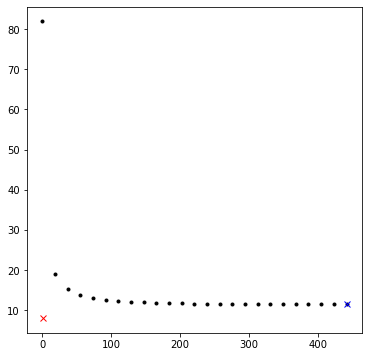

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(KList, xiList, "k.")
plt.plot(finalParams[1], xif, "rx")
plt.plot(KList[np.argmin(xiList)], np.min(xiList), "bx")

In [ ]:
# for params in paramList:
#     GP = vK2KGPR.vonKarman2KernelGPR(dC, curl=True)
#     dC.JackKnife(GP)
#     xi0, xif = dC.JackKnifeXi()